# Setup

## Choose a city and the output Folder

In [1]:
from IPython.utils import capture
import os

#@markdown Choose a city:
chosen_city = 'florence' #@param ['florence', 'rome', 'milan_big']
output_folder = './drive/MyDrive/SimulationOutputs/' #@param
output_folder += chosen_city+'/'

os.makedirs(output_folder, exist_ok=True)
root = os.getcwd()

## Install the libraries and files

In [2]:
# with capture.capture_output() as cap:
#     !pip install -U routing_lib
#     !pip install -U pattern_optimized_routes
#     !git clone https://github.com/lwdovico/pattern-optimized-routes $root/pattern-optimized-routes

## Prepare files and network

Unzip files in the folder cloned from the repository

In [3]:
# # RUN IF YOU NEED TO UNZIP THE FIRST TIME
# import zipfile

# # Path to the zip file
# zip_file_path = f'{root}/pattern-optimized-routes/data/road_networks.zip'
# extract_to_directory = f'{root}/pattern-optimized-routes/data/'

# # Open the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_directory)

In [4]:
import sumolib
from routing_lib import from_sumo_to_igraph_network

road_network_path = f'{root}/pattern-optimized-routes/data/{chosen_city}_road_network.net.xml'
mobility_demand_path = f'{root}/pattern-optimized-routes/data/dict_mobility_demand_{chosen_city}.json'

road_network = sumolib.net.readNet(road_network_path, withInternal=False)
G = from_sumo_to_igraph_network(road_network)

### Visualize network location

In [ ]:
import folium
from meru.multilevel import get_map_shape

def get_boundary_network_map(location_folium, map_shape):
    m = folium.Map(location = location_folium, tiles = 'cartodbpositron', zoom_start=12)
    folium.PolyLine(locations=[(y, x) for x, y in map_shape.boundary[0].coords], weigth=4, color='blue', opacity=1).add_to(m)
    return m
    
# computing them for later anyway
map_shape = get_map_shape(G)
city_center = map_shape.centroid[0].coords[0]
location_folium = list(reversed(city_center))

nmap = get_boundary_network_map(location_folium, map_shape)
nmap

# Extract all the $K_{road}$ distributions

It extract only the 1st level to show the parameter tuning reasoning process

In [2]:
from meru.multilevel import MultiLevelModel

k = 3
attribute = 'traveltime'
random_state = 42
distributions_to_test = [200, 500, 1000, 2000, 3500, 5000, 7000, 12000, 15000, 
                         17000, 20000, 30000, 50000, 75000, 100000, 200000]

# I wrote here for clarity what are basically default parameters
params = {'default_vehicles' : 3500, # if it fails it gives this n° of vehicles
          'tuning_parameters' : distributions_to_test}
meru_model = MultiLevelModel(G, k, attribute, params = params)

print('Performing parameter selection!')

# If you apply a balance threshold of 1 it will fail to find the correct parameter
# I am doing it to show the distributions of all the parameters
meru_model.parameter_selection(balance_threshold = 1.0, verbose = True, random_state = random_state)

C:\Users\Ludovico\anaconda3\envs\TestingLibrary\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Ludovico\anaconda3\envs\TestingLibrary\lib\site-packages\skmob\tessellation\tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


Performing parameter selection!
100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [06:49<00:00, 488.72it/s]
Parameter Selection Failed, using default_vehicles parameter:  3500


## Visualize the distribution boxplots

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_tested_parameters_distributions(tested_parameters, log = False, show = False):
    get_clean_dist = lambda x: np.log2(x)[np.log2(x) > -np.inf] if log else x
    plt.boxplot([get_clean_dist(list(kroad_distribution[1].values())) for _, kroad_distribution in tested_parameters])
    plt.xticks(np.arange(len(tested_parameters)+1), [0]+[str(value_tested/1000).replace('.0', '')+'k' for value_tested, _ in tested_parameters], fontsize = 8)

### Looking at the Kroad distributions

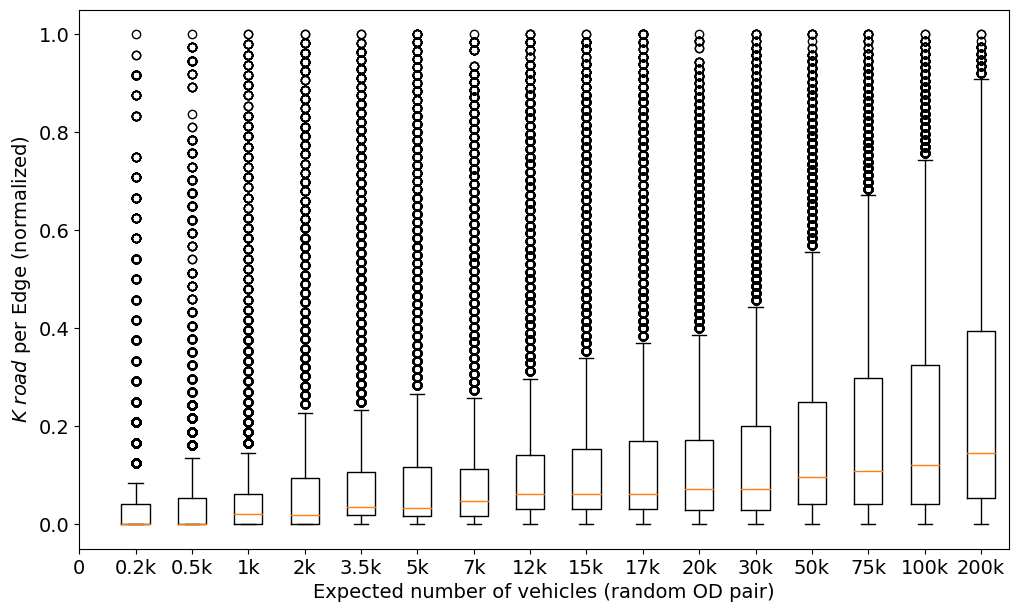

In [25]:
plt.figure(figsize = (12, 7))
visualize_tested_parameters_distributions(meru_model.tested_parameters)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('$K$ $road$ per Edge (normalized)', fontsize = 14)
plt.xlabel('Expected number of vehicles (random OD pairs)', fontsize = 14)
plt.show()

### Looking at the Kroad distributions (logs)

The log are important because they are the basis of the tuning since the log-normality requires normal distributions in the logarithmic space. My tuning approach is based on "first quasi-balanced distribution is ok" to save computing cost (larger number of vehicles tested requires a lot more computational power, while the improvement is not that large)

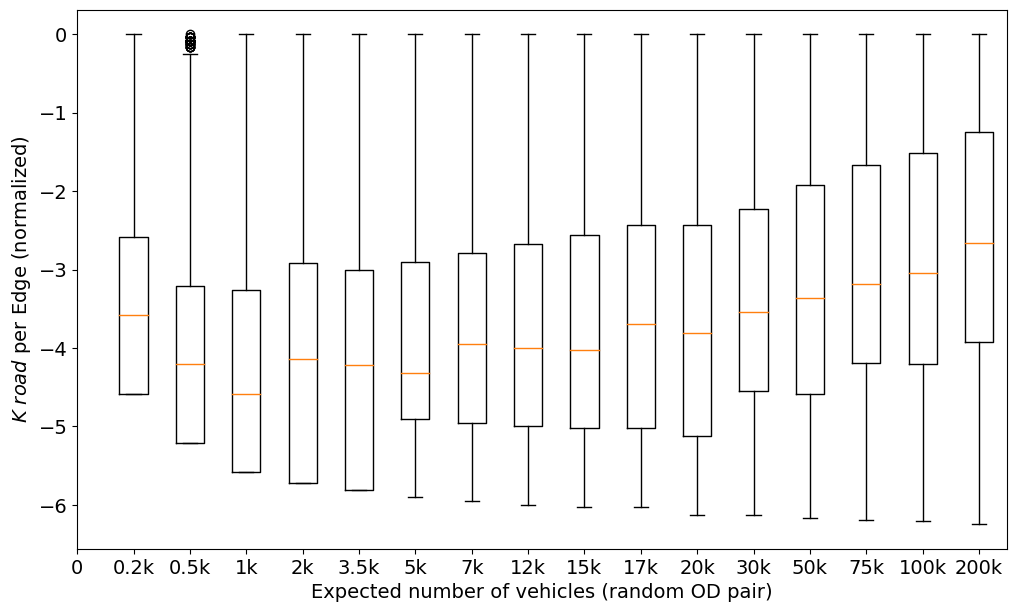

In [26]:
plt.figure(figsize = (12, 7))
visualize_tested_parameters_distributions(meru_model.tested_parameters, log = True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('$K$ $road$ per Edge (normalized)', fontsize = 14)
plt.xlabel('Expected number of vehicles (random OD pairs)', fontsize = 14)
plt.show()

Now the balance threshold (it is the relative difference between the smallest value and Q1, 
The balance is set to 0 by default = it is enough for the smallest value to be different from the first quartile

# Perform parameter selection

In [29]:
from meru.multilevel import MultiLevelModel

k = 3
attribute = 'traveltime'
random_state = 42

meru_model = MultiLevelModel(G, k, attribute)

print('Performing parameter selection!')

meru_model.parameter_selection(verbose = False, random_state = random_state)

fitted_vehicles = meru_model.fitted_vehicles
print('Parameter Selected:', meru_model.fitted_vehicles)
meru_model.fit(random_state = random_state)
edges_weights = meru_model.weights

Performing parameter selection!
Parameter Selected: 5000
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 583.59it/s]


### This is the result of a single tuning
It stops when it reaches the balance threshold, which is usually set to 0 (as it can be seen the last distribution has Q1 and the minimum value separated)

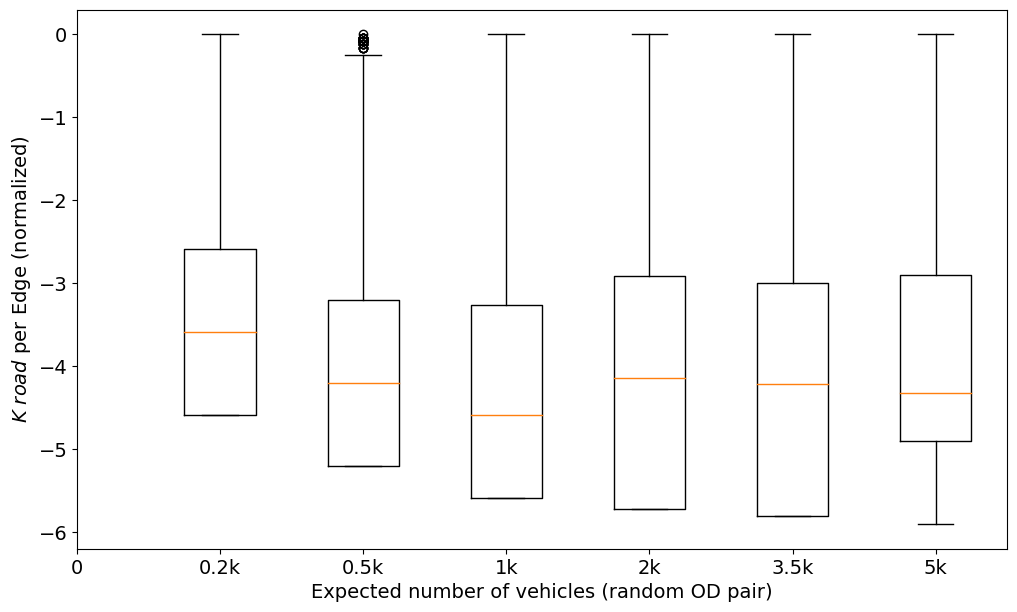

In [38]:
plt.figure(figsize = (12, 7))
visualize_tested_parameters_distributions(meru_model.tested_parameters, log = True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('$K$ $road$ per Edge (normalized)', fontsize = 14)
plt.xlabel('Expected number of vehicles (random OD pairs)', fontsize = 14)
plt.show()

Showing the popularity of the fitted contemporary vehicle parameter. I present the first level as it is supposed to be the most relevant (the basic expected road usage)

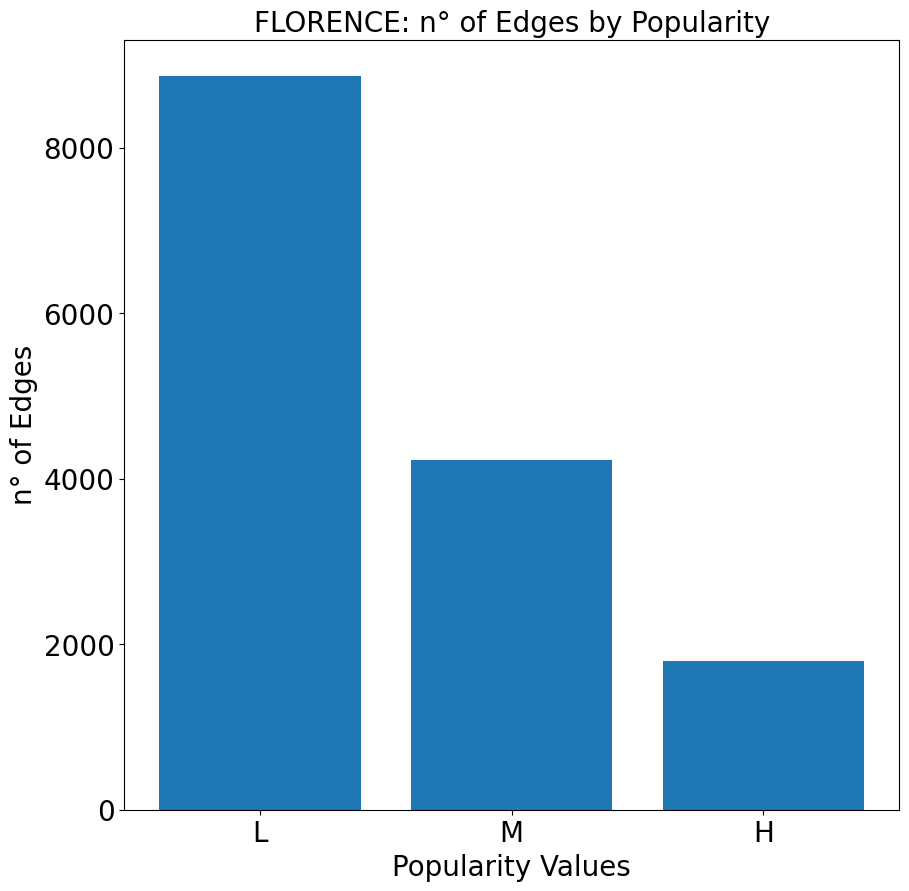

In [41]:
from meru.extract_measures import count_popularity

edge_weights = meru_model.weights[1]
map_count = count_popularity(edge_weights)

plt.figure(figsize = (10, 10))
plt.bar(map_count.keys(), map_count.values())
plt.title(f'{chosen_city.replace("_big", "").upper()}: n° of Edges by Popularity', fontsize = 20)
plt.ylabel('n° of Edges', fontsize = 20)
plt.xlabel('Popularity Values', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

# Showing the difference of the first level and the last on maps

Highest K road values (ERU in the contex of this algorithm) is darker

In [ ]:
from meru.multilevel import get_kroad_maps

# maps = get_kroad_maps(G, edges_weights)

dm = folium.plugins.DualMap(location = location_folium, tiles = 'cartodbpositron', zoom_start=13)

for e in G.es:

    edge_locs = [tuple(reversed(coord)) for coord in (e['coordinates']['from'], e['coordinates']['to'])]

    for lvl, m in ((1, dm.m1), (3, dm.m2)):
        kr = edges_weights[lvl][e['original_id']]
        folium.PolyLine(locations=edge_locs, weigth=4, color='blue', opacity=kr).add_to(m)

dm

# Measure CO2 for each distribution of parameters

#### WARNING: It may take hours, days or more to test all the parameters I used as defaults. For a quick test select only a few with low values.

In [ ]:
from meru.testing import pipeline_test_reproducible_kdistributions

%env SUMO_HOME=/usr/share/sumo

# # This may require a lot of time
# all_distributions = [200, 500, 1000, 2000, 3500, 5000, 7000, 12000, 15000, 17000, 20000, 30000, 50000, 75000, 100000, 200000]

all_distributions = [fitted_vehicles]

results_dist = pipeline_test_reproducible_kdistributions(road_network_path, output_folder, mobility_demand_path,
                                                         distributions_to_test=all_distributions, experiment_per_rs = 10,
                                                         random_state = 42)

#### Get average measures of all tested parameters

In [78]:
import pandas as pd

dist_df = pd.read_csv(f'{output_folder}simulation_results.csv')
results_dist = {'measures' : dist_df[dist_df['algorithm_name'].str.contains('MERU')]}

In [79]:
dict(results_dist['measures'].mean())

{'random_state': 124000.8,
 'CO2 Tons': 28.635625576076258,
 'Vehicles Traveltime': 9505117.8,
 'N Teleports': 691.0,
 'Avg Diversity of Suggestions': 0.3898144994009864,
 'Std Diversity of Suggestions': 0.2540283259722834,
 'N Vehicles (Traveled Paths)': 10000.0,
 'Road Coverage': 0.7422281179306511,
 'N Traveled Edges': 511913.2,
 'Edge Coverage': 0.7126906133514064,
 'Avg Traveled Edge Traveltime': 5.865119360828343,
 'Std Traveled Edge Traveltime': 10.582851461364607,
 'Avg Traveled Path Traveltime': 300.2387642802188,
 'Std Traveled Path Traveltime': 195.76630572223527,
 'Total Redundancy': 60.85089757885227,
 'Interval Temp Redundancy (s)': 300.0,
 'Avg Temp Redundancy': 7.638014231748255,
 'Std Temp Redundancy': 0.2594058273415096,
 'Entropy': 301.35398413468954}

In [80]:
dict(results_dist['measures'].std())

{'random_state': 261422.1737160029,
 'CO2 Tons': 1.2549405056904508,
 'Vehicles Traveltime': 495616.8283004747,
 'N Teleports': 111.30139262381222,
 'Avg Diversity of Suggestions': 0.005531868105032774,
 'Std Diversity of Suggestions': 0.004436514917562751,
 'N Vehicles (Traveled Paths)': 0.0,
 'Road Coverage': 0.0017938282404335035,
 'N Traveled Edges': 2456.8162686244527,
 'Edge Coverage': 0.0023011591979091575,
 'Avg Traveled Edge Traveltime': 0.023771569114879258,
 'Std Traveled Edge Traveltime': 0.05180700669892636,
 'Avg Traveled Path Traveltime': 0.7715723819113791,
 'Std Traveled Path Traveltime': 1.2247825751202046,
 'Total Redundancy': 0.2525945446015378,
 'Interval Temp Redundancy (s)': 0.0,
 'Avg Temp Redundancy': 0.04070803613533897,
 'Std Temp Redundancy': 0.02165629785580156,
 'Entropy': 1.601840933687828}

### Split the CSV to have the results of comparisons with the Baselines in different files

I just extract and backup the distribution files, while I extract the fitted vehicles parameter records and create a new file with it where the baseline tests will be stored

In [218]:
df = pd.read_csv(f'{output_folder}simulation_results.csv')
contains_meru = df['algorithm_name'].str.contains('MERU')
contains_fitted = df['algorithm_name'].str.contains(f'MERU{fitted_vehicles}')

df_meru, df_not_only_meru = df[contains_meru], pd.concat((df[~contains_meru], df[contains_fitted]))

df_meru.to_csv(f'{output_folder}{chosen_city}_distributions_simulation_results.csv', index = False)
df_not_only_meru.to_csv(f'{output_folder}simulation_results.csv', index = False)

## Baselines

This block computes the results for the basselines according to the specified parameters (pay attention not to specify too many of them especially if there are multiple parameters as each combination is gonna be computed resulting in a combinatorial explosion and never ending process

#### WARNING: IT MAY TAKE DAYS TO END WITHOUT SAMPLING
Speed depends on hardware and network size mainly. Further more, GR, KML and PLAT are particularly slow. A quick test may require a sample of the mobility demand which can be done by setting the sample parameter to a low desired value to sample the OD pairs of which a path needs to be computed.

In [ ]:
from meru.testing import pipeline_test_reproducible_baselines

%env SUMO_HOME=/usr/share/sumo

# Original algorithm parameters
algorithm_parameters = {'NR' : {}
                        'KSP' : {},
                        'KD'  : {},
                        'PP'  : {'p' : [0.05, 0.2, 0.3, 0.4, 0.5]},
                        'KMD' : {'epsilon' : [0.2, 0.3]},
                        'GR'  : {'delta' : [0.2, 0.3, 0.4, 0.5], 'tau' : [0.2]},
                        'KML' : {'theta' : [0.6, 0.7, 0.8]},
                        'PLAT': {'epsilon' : [1.3, 2, 5, 15]}}

results = pipeline_test_reproducible_baselines(road_network_path, output_folder,
                                               mobility_demand_path, algorithm_parameters,
                                               #meru_model = meru_model,
                                               experiment_per_rs = 10)

# Manual Pipeline (Computing SERU)

### Imports

In [5]:
from datetime import datetime
from tqdm import tqdm
import numpy as np
import json
import pickle
import sys

from meru.extract_measures import get_resulting_paths_and_measures
from meru.simulate import save_sumo_routes
from meru.simulate import simulate_sumo_paths
from meru.simulate import save_results
from meru.multilevel import MultiLevelModel
from meru.baselines import BaselineModel
from routing_lib.routing_utils import visualize_paths

### Parameters

In [6]:
random_state = 42
k, attribute = 3, 'traveltime'

# to avoid the long selection process since it will result in these values
fitted_vehicle_city_map = {'florence' : 5000, 'milan_big' : 15000, 'rome' : 30000}

### Load mobility demand

In [8]:
with open(mobility_demand_path, 'r') as f:
    mobility_demand = json.loads(f.read())

# Get unique paths to predict (same OD pair)
od_set = sorted({tuple(mobility_demand[v]['edges']) for v in mobility_demand})

### Predict paths from edges and build two maps to see the difference

In [ ]:
# meru_model = MultiLevelModel(G, k, attribute)
# meru_model.parameter_selection(n_vehicles = fitted_vehicle_city_map[chosen_city])
# fitted_vehicles = meru_model.fitted_vehicles
# print('Parameter Selected:', fitted_vehicles)
# meru_model.fit(random_state = random_state)

# result_paths_seru = dict()
# result_paths_meru = dict()

# for from_edge, to_edge in tqdm(od_set, desc="Paths Computed"):
#     result_paths_seru[(from_edge, to_edge)] = meru_model.predict(from_edge, to_edge, k = k, multilevel = False)
#     result_paths_meru[(from_edge, to_edge)] = meru_model.predict(from_edge, to_edge, k = k, multilevel = True)

In [10]:
# np.random.seed(random_state)
# chosen_routes_seru = [np.random.choice(x) for x in result_paths_seru.values()]
# np.random.seed(random_state)
# chosen_routes_meru = [np.random.choice(x) for x in result_paths_meru.values()]

# def visualize_path_wrapper(paths, road_network, **kwargs):
#     paths = [p['edges'] for p in paths]
#     return visualize_paths(paths, road_network, **kwargs)

# opacity = 0.05
# map_seru = visualize_path_wrapper(chosen_routes_seru, road_network, opacity = opacity)
# map_meru = visualize_path_wrapper(chosen_routes_meru, road_network, opacity = opacity)

Note: it may seem that the visualization of the difference is not that large

In [11]:
map_seru.save('map_seru.html')
map_meru.save('map_meru.html')

### Traffic Assignment, Measures and Simulation

In [ ]:
%env SUMO_HOME=/usr/share/sumo

path_results = []
ew_results = []

seru_model = MultiLevelModel(G, 1, attribute) # 1 because I need only one Klevel since a simple solution is applied
seru_model.parameter_selection(n_vehicles = fitted_vehicle_city_map[chosen_city])
fitted_vehicles = seru_model.fitted_vehicles
print('Parameter Selected:', fitted_vehicles)

In [ ]:
rs = random_state

In [29]:
for exp in range(1, 10):

    print('Test n°:', exp, 
          'Parameter selected:', seru_model.fitted_vehicles, 
          'Random state selected:', rs)

    seru_model.fit(random_state = rs)
    seru_model.algorithm_name = 'SERU'+str(fitted_vehicles)
    edge_weights = seru_model.weights[1]

    # PREDICT PATHS
    result_paths = dict()
    for from_edge, to_edge in tqdm(sorted(od_set), desc="Paths Computed"):
        result_paths[(from_edge, to_edge)] = seru_model.predict(from_edge, to_edge, k = k, multilevel = False)

    paths_and_measures = get_resulting_paths_and_measures(road_network, mobility_demand, result_paths, edge_weights, attribute, seru_model.algorithm_name,
                                                          selection_criterion = np.random.choice, random_state = rs, G = G)
    
    # SAVING WEIGHTS AND PATHS
    ew_results.append((rs, edge_weights))
    path_results.append((rs, paths_and_measures['paths']))

    current_time = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    file_name = f'{seru_model.algorithm_name}_{current_time}'
    save_sumo_routes(paths_and_measures['paths'], mobility_demand, save_path = output_folder, name = file_name)

    # SIMULATION
    route_filename = f'{output_folder}/sumo_routes_{file_name}.rou.xml'
    simulation_result = simulate_sumo_paths(paths_and_measures, road_network_path, route_filename)
    print('******************')
    for key, value in simulation_result.items():
        print(f'{key}: {value}')
    print('******************\n')

    df_measure_results = save_results(paths_and_measures['measures'], save_path = output_folder)
    
    rs *= 3 # update random state to change results

Test n°: 1 Parameter selected: 5000 Random state selected: 126
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 572.91it/s]


Paths Computed: 100%|██████████████████████████████████████████████████████████████| 7207/7207 [01:45<00:00, 68.18it/s]


SUMO 1.15.0 and TraffiCO2 version 2.03


Vehicles Arrived: 100%|██████████████████████████████████████████████████████████| 10000/10000 [02:57<00:00, 56.49it/s]


******************
Execution time (s): 177.0210199356079
Number of teleports: 1238
Total CO2 Tons: 30.94248061908288
Total travletime (s): 10205041
******************

Test n°: 2 Parameter selected: 5000 Random state selected: 378
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 544.42it/s]


Paths Computed: 100%|██████████████████████████████████████████████████████████████| 7207/7207 [01:49<00:00, 65.83it/s]


SUMO 1.15.0 and TraffiCO2 version 2.03


Vehicles Arrived: 100%|██████████████████████████████████████████████████████████| 10000/10000 [03:05<00:00, 54.03it/s]


******************
Execution time (s): 185.09524941444397
Number of teleports: 1103
Total CO2 Tons: 31.08244058035528
Total travletime (s): 10278942
******************

Test n°: 3 Parameter selected: 5000 Random state selected: 1134
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 538.82it/s]


Paths Computed: 100%|██████████████████████████████████████████████████████████████| 7207/7207 [01:44<00:00, 68.99it/s]


SUMO 1.15.0 and TraffiCO2 version 2.03


Vehicles Arrived: 100%|██████████████████████████████████████████████████████████| 10000/10000 [03:03<00:00, 54.41it/s]


******************
Execution time (s): 183.77903699874878
Number of teleports: 1237
Total CO2 Tons: 31.496941758928845
Total travletime (s): 10472710
******************

Test n°: 4 Parameter selected: 5000 Random state selected: 3402
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 498.62it/s]


Paths Computed: 100%|██████████████████████████████████████████████████████████████| 7207/7207 [02:16<00:00, 52.64it/s]


SUMO 1.15.0 and TraffiCO2 version 2.03


Vehicles Arrived: 100%|██████████████████████████████████████████████████████████| 10000/10000 [04:31<00:00, 36.87it/s]


******************
Execution time (s): 271.1983377933502
Number of teleports: 2053
Total CO2 Tons: 38.89044144240181
Total travletime (s): 13307215
******************

Test n°: 5 Parameter selected: 5000 Random state selected: 10206
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 326.43it/s]


Paths Computed: 100%|██████████████████████████████████████████████████████████████| 7207/7207 [02:36<00:00, 46.05it/s]


SUMO 1.15.0 and TraffiCO2 version 2.03


Vehicles Arrived: 100%|██████████████████████████████████████████████████████████| 10000/10000 [03:53<00:00, 42.86it/s]


******************
Execution time (s): 233.29661059379578
Number of teleports: 1267
Total CO2 Tons: 30.987626533596917
Total travletime (s): 10197660
******************

Test n°: 6 Parameter selected: 5000 Random state selected: 30618
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 346.94it/s]


Paths Computed: 100%|██████████████████████████████████████████████████████████████| 7207/7207 [02:37<00:00, 45.67it/s]


SUMO 1.15.0 and TraffiCO2 version 2.03


Vehicles Arrived: 100%|██████████████████████████████████████████████████████████| 10000/10000 [04:06<00:00, 40.52it/s]


******************
Execution time (s): 246.81949067115784
Number of teleports: 1264
Total CO2 Tons: 32.29200039996138
Total travletime (s): 10719318
******************

Test n°: 7 Parameter selected: 5000 Random state selected: 91854
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 372.45it/s]


Paths Computed: 100%|██████████████████████████████████████████████████████████████| 7207/7207 [02:50<00:00, 42.38it/s]


SUMO 1.15.0 and TraffiCO2 version 2.03


Vehicles Arrived: 100%|██████████████████████████████████████████████████████████| 10000/10000 [04:20<00:00, 38.39it/s]


******************
Execution time (s): 260.4871847629547
Number of teleports: 1231
Total CO2 Tons: 32.24284613384369
Total travletime (s): 10743186
******************

Test n°: 8 Parameter selected: 5000 Random state selected: 275562
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 360.33it/s]


Paths Computed: 100%|██████████████████████████████████████████████████████████████| 7207/7207 [02:33<00:00, 47.08it/s]


SUMO 1.15.0 and TraffiCO2 version 2.03


Vehicles Arrived: 100%|██████████████████████████████████████████████████████████| 10000/10000 [04:31<00:00, 36.80it/s]


******************
Execution time (s): 271.72708344459534
Number of teleports: 1573
Total CO2 Tons: 37.04851472322521
Total travletime (s): 12614406
******************

Test n°: 9 Parameter selected: 5000 Random state selected: 826686
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 377.20it/s]


Paths Computed: 100%|██████████████████████████████████████████████████████████████| 7207/7207 [02:33<00:00, 46.89it/s]


SUMO 1.15.0 and TraffiCO2 version 2.03


Vehicles Arrived: 100%|██████████████████████████████████████████████████████████| 10000/10000 [04:09<00:00, 40.10it/s]


******************
Execution time (s): 249.3610246181488
Number of teleports: 1117
Total CO2 Tons: 33.15497587258494
Total travletime (s): 11051828
******************



## Plot Measures For All Algorithms

In [224]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import math

df_source = pd.read_csv(f'{output_folder}/simulation_results.csv')

In [225]:
def clean_counter(x):
    return x.replace('Counter({', '{').replace('})', '}')

def decounter_column(series):
    return series.astype(str).apply(clean_counter).apply(eval)

colors_map = {}

for x in df_source['algorithm_name']:
    if x == 'NR' or x == 'KD':
        colors_map[x] = '#ababab'
    elif 'SERU' in x:
        colors_map[x] = '#5A5A5A'
    elif 'MERU' in x:
        colors_map[x] = '#0d0d0d'
    else:
        colors_map[x] = '#dbd9d9'

chosen_map = {'florence' : 5000,
              'milan_big' : 15000,
              'rome' : 30000}

fitted_vehicles = chosen_map[chosen_city]

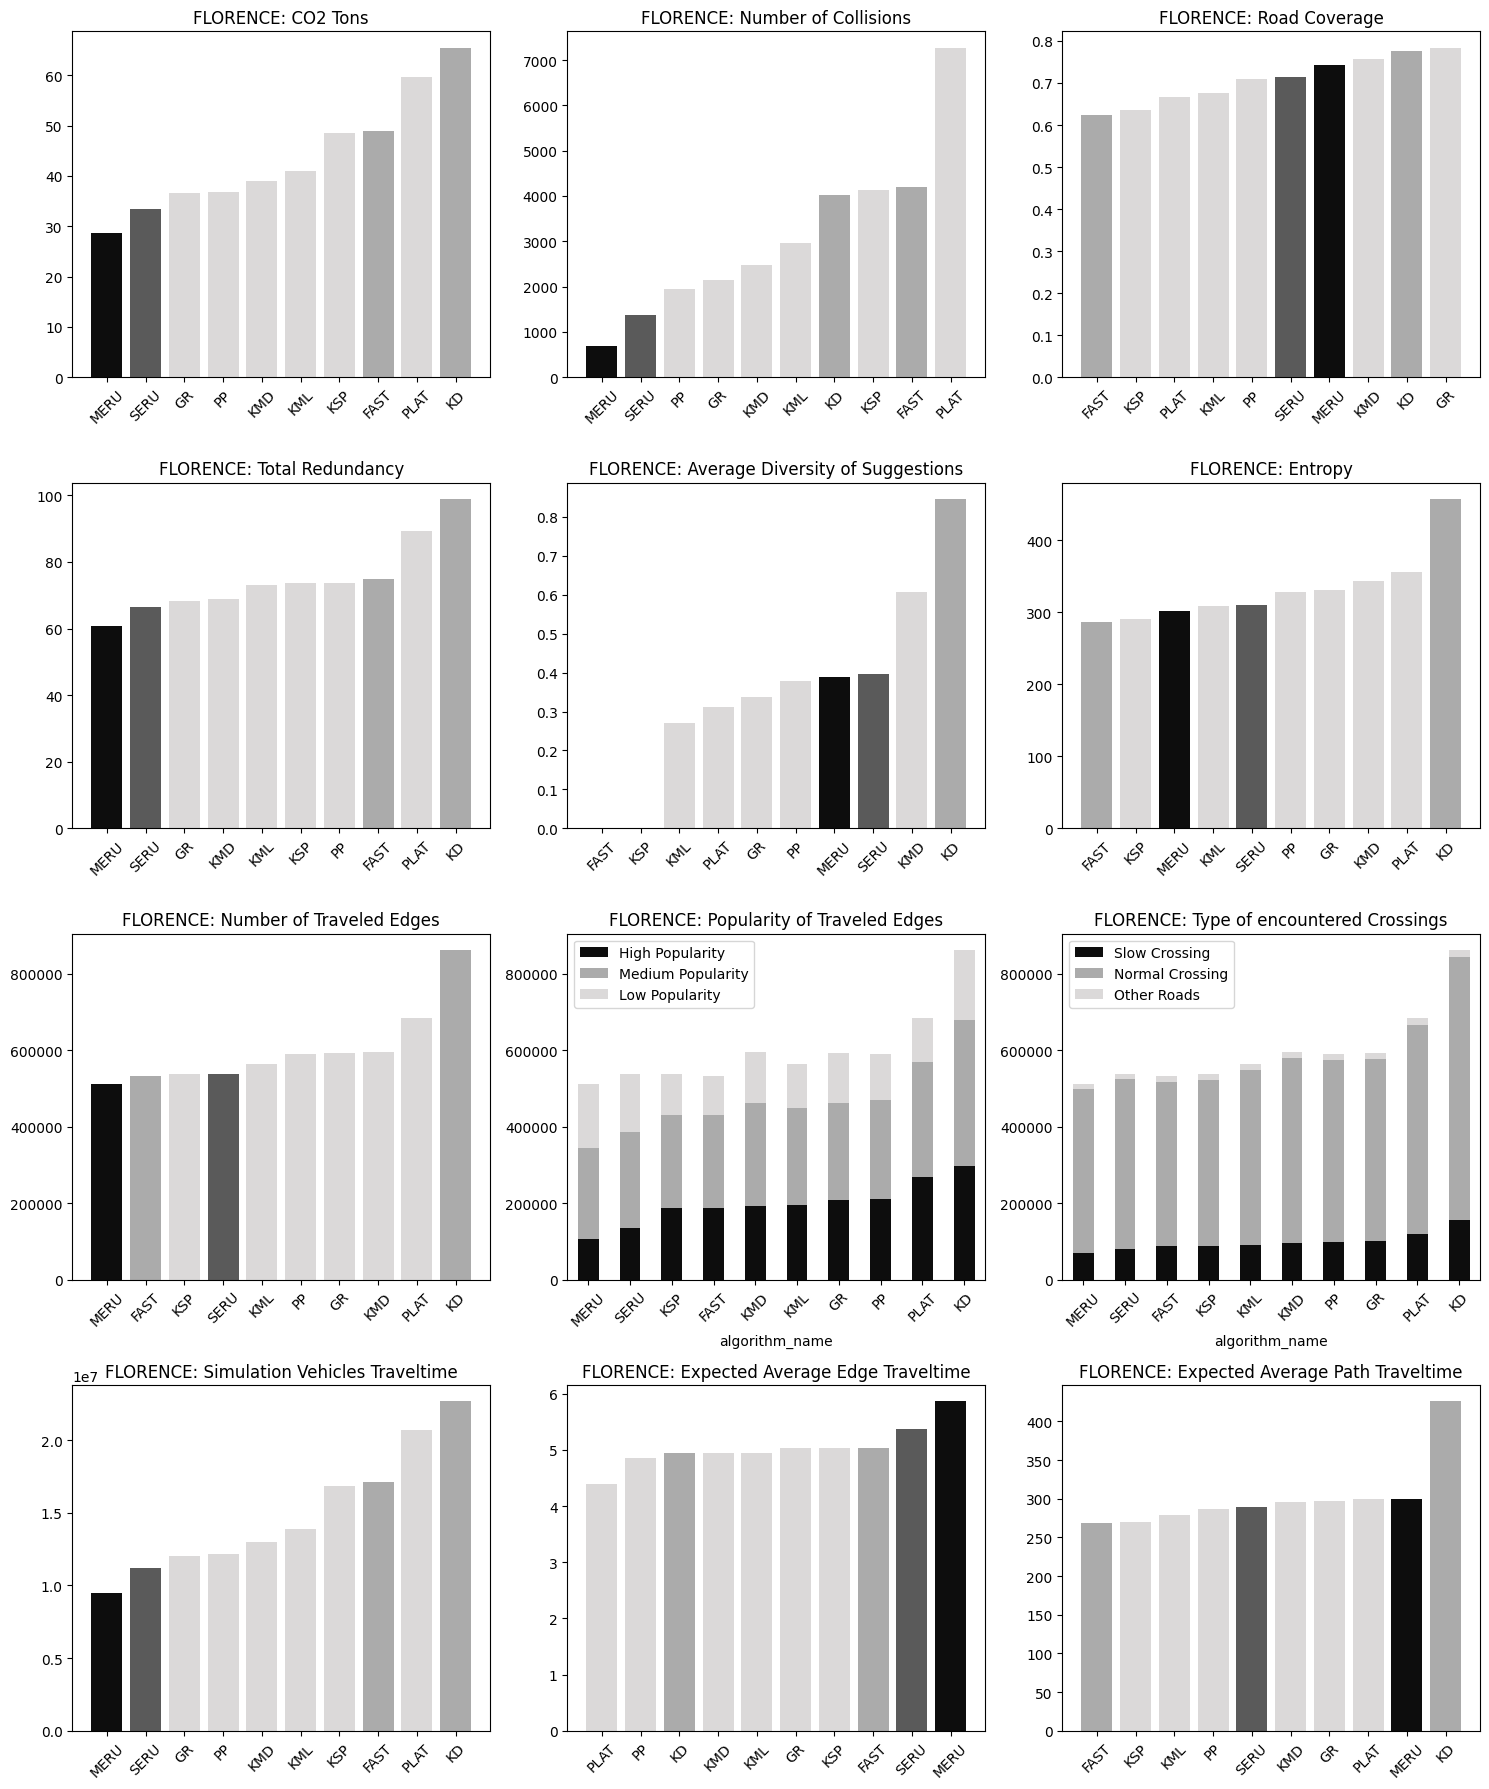

In [227]:
special_cols = {'Popularity of Traveled Edges' : ['H', 'M', 'L'], 'Type of encountered Crossings' : ['slow_crossing', 'normal_crossing', 'not_crossing']}
map_special_cols = {'Popularity of Traveled Edges' : {'H' : 'High Popularity', 'M' : 'Medium Popularity', 'L' : 'Low Popularity'}, 
                    'Type of encountered Crossings' : {'slow_crossing' : 'Slow Crossing', 'normal_crossing' : 'Normal Crossing', 'not_crossing' : 'Other Roads'}}

cols = {'algorithm_name': 'algorithm_name',
         'CO2 Tons': 'CO2 Tons',
         'N Teleports': 'Number of Collisions',
         'Road Coverage': 'Road Coverage',
         'Total Redundancy': 'Total Redundancy',
         'Avg Diversity of Suggestions': 'Average Diversity of Suggestions',
         'Entropy': 'Entropy',
         'N Traveled Edges': 'Number of Traveled Edges',
         'Traveled Popularity': 'Popularity of Traveled Edges',
         'Traveled Crossings': 'Type of encountered Crossings',
         'Vehicles Traveltime': 'Simulation Vehicles Traveltime',
         'Avg Traveled Edge Traveltime': 'Expected Average Edge Traveltime',
         'Avg Traveled Path Traveltime': 'Expected Average Path Traveltime'}

df = df_source[list(cols)]
df.columns = list(map(lambda x: cols[x], df.columns))
cols_to_plot = df.columns[1:]

measure = 'CO2 Tons'
to_plot = df[measure].groupby(df['algorithm_name']).mean()
to_plot = pd.DataFrame(to_plot)
to_plot = to_plot.sort_values(by = measure).reset_index()
to_plot['algorithm_prefix'] = to_plot['algorithm_name'].str.split('_').str[0]

# Find the rows with the lowest CO2 Tons for each algorithm prefix
result_df = to_plot.groupby('algorithm_prefix').apply(lambda x: x[x['CO2 Tons'] == x['CO2 Tons'].min()])
# Reset index to clean up the DataFrame
result_df = result_df.reset_index(drop=True)
# Drop the algorithm_prefix column if you don't need it anymore
result_df = result_df.drop(columns=['algorithm_prefix'])

lowest_CO2_ls = result_df['algorithm_name'].tolist()

# Create a list to hold subplots
fig, axes = plt.subplots(math.ceil(len(cols_to_plot)/3), 3, figsize=(15, 18))

# Flatten the axes list for easy indexing
axes = axes.flatten()

for idx, measure in enumerate(cols_to_plot):
    if measure not in special_cols:
        to_plot = df[measure].groupby(df['algorithm_name']).mean().fillna(0)
        to_plot = pd.DataFrame(to_plot)
        to_plot['colors'] = list(map(lambda x: colors_map[x], to_plot.index))
        to_plot = to_plot.sort_values(by = measure)
        to_plot = to_plot.loc[to_plot.index.isin(lowest_CO2_ls)]
        to_plot['algorithm_prefix'] = to_plot.index.str.split('_').str[0]
        to_plot['algorithm_prefix'] = to_plot['algorithm_prefix'].replace(f'MERU{fitted_vehicles}', 'MERU').replace(f'SERU{fitted_vehicles}', 'SERU').replace('NR', 'FAST')
        to_plot.index = to_plot['algorithm_prefix']
        to_plot.index.name = 'algorithm_name'
        
        axes[idx].bar(to_plot.index, to_plot[measure].values, color = to_plot['colors'].values)
        axes[idx].set_title(f"{chosen_city.replace('_big', '').upper()}: {measure}")
    else:
        temp_df = pd.DataFrame(decounter_column(df[measure]))

        # Initialize an empty DataFrame to hold the extracted values
        extracted_df = pd.DataFrame()

        # Iterate through rows to extract values from dictionaries
        for index, row in temp_df.iterrows():
            extracted_df = pd.concat((extracted_df, pd.DataFrame(row[measure], index = np.arange(1))), ignore_index=True)
        if 'Ratio' not in measure:
            extracted_df = extracted_df[special_cols[measure]]
        extracted_df['algorithm_name'] = df['algorithm_name']
        filtered_df = extracted_df.loc[extracted_df['algorithm_name'].isin(lowest_CO2_ls)]
        to_plot = filtered_df.groupby(filtered_df['algorithm_name']).mean()
        to_plot['algorithm_prefix'] = to_plot.index.str.split('_').str[0]
        to_plot['algorithm_prefix'] = to_plot['algorithm_prefix'].replace(f'MERU{fitted_vehicles}', 'MERU').replace(f'SERU{fitted_vehicles}', 'SERU').replace('NR', 'FAST')
        to_plot = to_plot.reset_index(drop = True).set_index(to_plot['algorithm_prefix'].values).drop('algorithm_prefix', axis = 1)
        to_plot.index.name = 'algorithm_name'

        # Create a stacked bar plot
        to_plot = to_plot.sort_values(by = special_cols[measure]).fillna(0)
        to_plot.columns = list(map(lambda x: map_special_cols[measure][x], to_plot.columns))
        to_plot.plot(kind='bar', stacked=True, ax=axes[idx], color = ['#0d0d0d', '#ababab', '#dbd9d9'])
        axes[idx].set_title(f"{chosen_city.replace('_big', '').upper()}: {measure}")

    axes[idx].set_xticks(axes[idx].get_xticks())
    axes[idx].set_xticklabels(to_plot.index, rotation=45)

# Remove any extra empty subplots
for i in range(len(cols_to_plot), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
